In [1]:
import os
from tqdm import tqdm
import pickle
import random

import pandas as pd
import numpy as np
import scipy
from sklearn.metrics.pairwise import pairwise_kernels
import matplotlib.pyplot as plt
from matplotlib import image
import seaborn as sns
from collections import defaultdict, Counter

from metaspace import SMInstance
from anndata import AnnData
from metaspace_converter import metaspace_to_anndata
from datetime import date, datetime 
import time

import utils
from coloc_utils import *
%load_ext autoreload
%autoreload 2

/home/trose/.conda/envs/metabolomics2/lib/python3.10/site-packages/linex2/parser.py:22: RuntimeWarning: Package 'lynx' (LipidLynxX) not available. Lipid name conversions will not be possible.
  warnings.warn(


# Load data

In [2]:
from config import date_key, data_dir, store_dir, figuredata_dir

In [3]:
dss = pickle.load(open(os.path.join(store_dir, 'all_datasets.pickle'), "rb" ) )
results = pickle.load(open(os.path.join(store_dir, 'hmdb4_results.pickle'), "rb" ) )

In [4]:
md = utils.make_metadata_dict(dss, results, fdrcutoff=0.05)
mdt = utils.clean_metadata_table(utils.metadata_dict_totable(md))

# Helper functions

In [5]:
def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = datetime(year=year, month=1, day=1)
    startOfNextYear = datetime(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

def apd(results, fdr_cutoff=0.05):
    n_anno = []
    for tab in results.values():
        if tab[tab['fdr'] <= fdr_cutoff].shape[0] >0:
            n_anno.append(tab[tab['fdr'] <= fdr_cutoff].shape[0])
            
    return n_anno

def dpa(results, fdr_cutoff=0.05):
    dpad = defaultdict(int)
    for tab in results.values():
        tmp = list(tab[tab['fdr'] <= fdr_cutoff].index)
        for t in tmp:
            dpad[t] += 1
    return dpad

# Knowledge base statistics

In [6]:
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALLSMALL_SIZE, title_fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [7]:
# img = image.imread('drawings/metaspace_sketch.png')
# msc1 = image.imread('drawings/metaspace_screenshot1.png')
# msc2 = image.imread('drawings/metaspace_screenshot2.png')

## Submissions

In [8]:
# All dataset IDs are not public and therefore not available on GitHub
# Comment out the whole cell if table is not available
all_ds_ids = pd.read_csv(os.path.join(data_dir, 'all_dataset_ids-2024-04-04.csv'))
all_ds_ids['dataset_id'] = all_ds_ids['dataset_id'].apply(lambda x: toYearFraction(date.fromisoformat(x.split('_')[0])))
all_ds_ids['Datasets'] = 'All'
all_ds_ids = all_ds_ids.rename(columns={'dataset_id':'Date'})
all_ds_ids = all_ds_ids.sort_values('Date')
all_ds_ids['Submissions'] = np.arange(all_ds_ids.shape[0])

In [9]:
sm = SMInstance()
new_datasets = sm.datasets()

In [10]:
public_ids = pd.DataFrame({'Date': [toYearFraction(date.fromisoformat(x.id.split('_')[0])) for x in new_datasets]})
public_ids = public_ids[public_ids['Date'] <= all_ds_ids['Date'].max()]
public_ids['Datasets'] = 'Public'
public_ids = public_ids.sort_values('Date')
public_ids['Submissions'] = np.arange(public_ids.shape[0])

## Contributors

In [18]:
grp = []
sbmttr = []

submitter_scaling = 50

for ds in dss:
    if not (ds.group is None or ds.submitter is None):
        grp.append(ds.group['shortName'])
        sbmttr.append(ds.submitter['id'])

labs = pd.DataFrame({'Lab': grp, 'Submitter': sbmttr})
#labs.groupby('Lab').nunique()
labs = labs.groupby('Lab').agg('count').rename(columns={'Submitter': 'Datasets'}).join(labs.groupby('Lab').nunique())
labs['Submitter'] = - labs['Submitter'] * submitter_scaling
labs = labs.sort_values('Datasets', ascending=False).reset_index()
labs = labs[:15]
labs['Lab'] = labs['Lab'].replace({'♡EMBL♡': 'EMBL'})

## Organisms/Organs

In [12]:
org_org = mdt[['Organism', 'Organism_Part']].rename(columns={'Organism_Part': 'Organ'}).reset_index()  # .groupby(['Organism', 'Organ']).agg('count')
most_organs = list(org_org.groupby('Organ').agg('count').sort_values('Organism', ascending=False).index[:10])
most_organisms = list(org_org.groupby('Organism').agg('count').sort_values('Organ', ascending=False).index[:3])

most_organisms = [x for x in most_organisms if x not in ['N/A', 'Multiple']]

org_org = org_org[org_org['Organism'].isin(most_organisms)]
org_org = org_org[org_org['Organ'].isin(most_organs)]


org_org2 = org_org.groupby(['Organism', 'Organ']).agg('count').reset_index()

## Figure assembly

In [13]:
tmp = mdt.groupby(['Polarity', 'maldi_matrix']).agg('count').reset_index().sort_values('Organism', ascending=False)
tmp = tmp[tmp['Organism']>=10]
tmp

,Polarity,maldi_matrix,Organism,Condition,Organism_Part,Group,mzmin,mzmax,Analyzer,Ionisation_Source
24,Positive,DHB,2648,2648,2648,2648,2586,2586,2648,2648
4,Negative,DAN,1076,1076,1076,1076,1033,1033,1076,1076
15,Negative,Other,1056,1056,1056,1056,1030,1030,1056,1056
31,Positive,Other,718,718,718,718,662,662,718,718
13,Negative,NEDC,534,534,534,534,527,527,534,534
19,Positive,CHCA,503,503,503,503,452,452,503,503
0,Negative,9AA,191,191,191,191,163,163,191,191
22,Positive,DHA,172,172,172,172,170,170,172,172
21,Positive,DAN,161,161,161,161,156,156,161,161
14,Negative,Norharmane,97,97,97,97,85,85,97,97


In [35]:
pd.concat([all_ds_ids, public_ids]).to_csv(os.path.join(figuredata_dir, 'submissions.csv'))

/tmp/ipykernel_485/2581366282.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right", rotation_mode="anchor")
/tmp/ipykernel_485/2581366282.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right", fontsize=SMALLSMALL_SIZE, rotation_mode="anchor")
/tmp/ipykernel_485/2581366282.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ylabs)
/tmp/ipykernel_485/2581366282.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, rotation_mode="anchor", ha="right")
/tmp

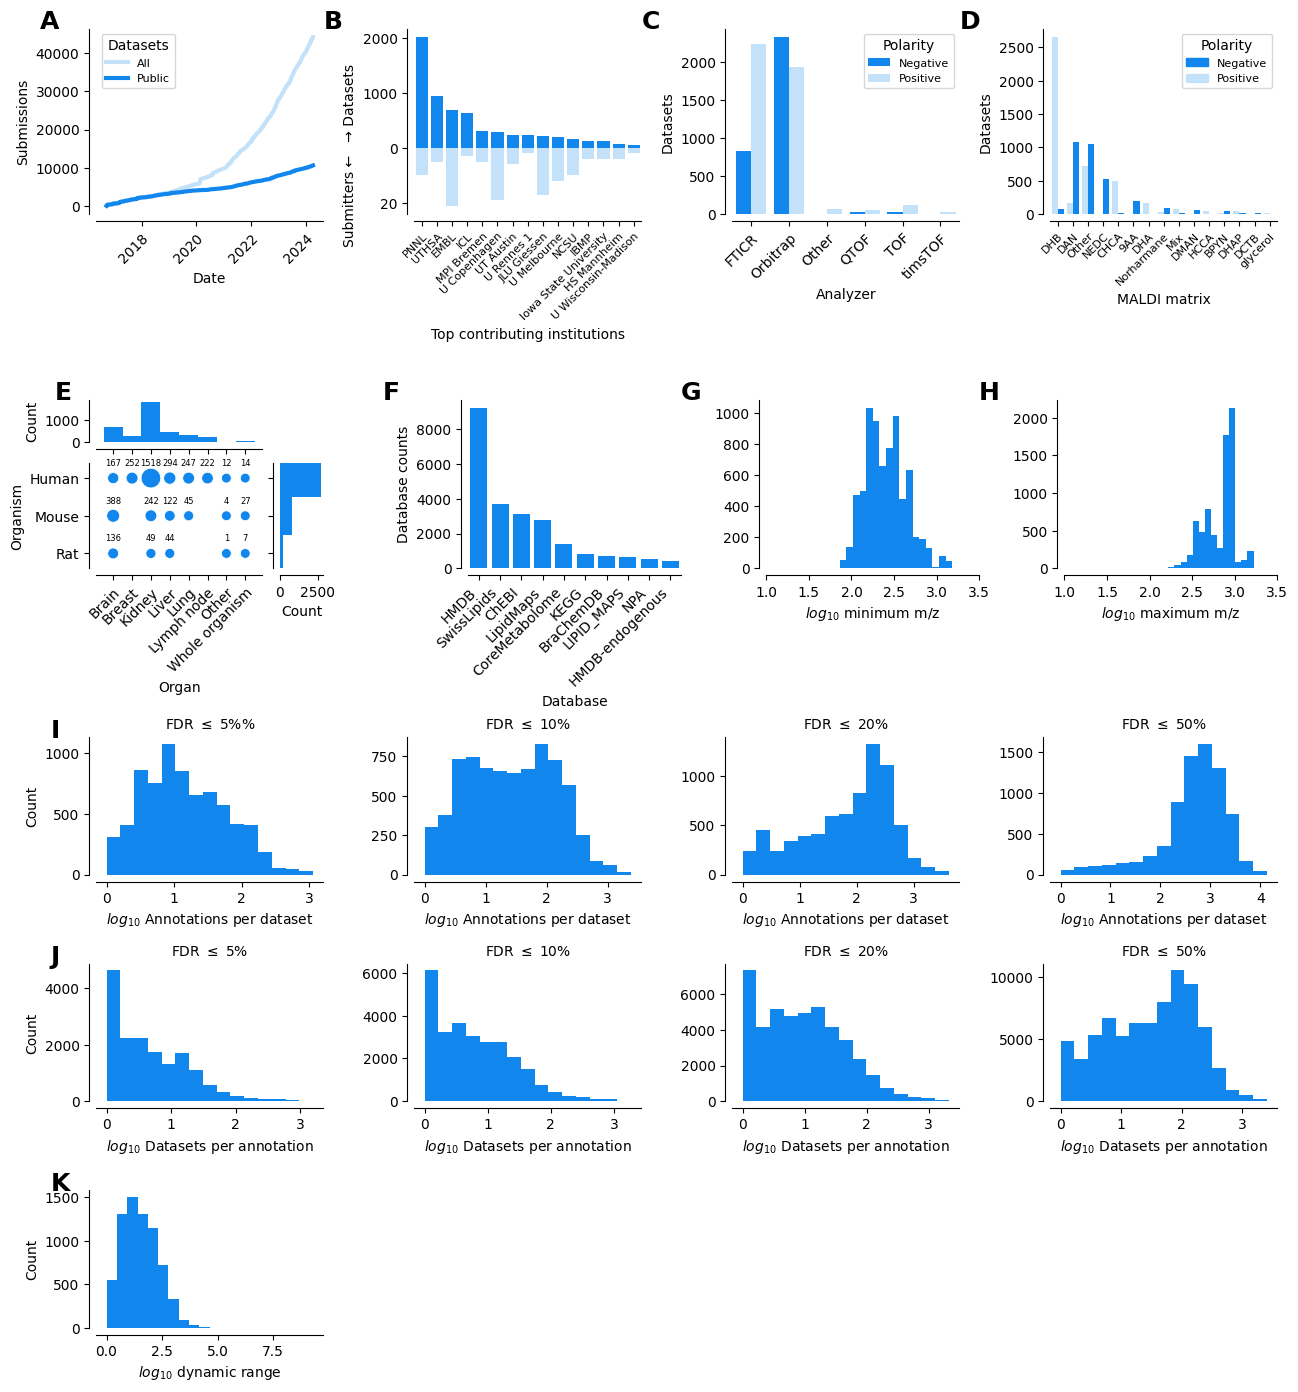

In [36]:
fig = plt.figure(figsize=(30*cm, 48*cm))

(part1fig, part2fig, part3fig) = fig.subfigures(3, 1, height_ratios=[1.1, 1., 3.5])

# ax = sketchfig.subplots(1,)
# sketchfig.subplots_adjust(hspace=0.0, wspace=0.0, left=.0, right=.9)
# ax.imshow(img, aspect='equal')
# ax.axis('off')
# ax.text(0, 1., 'A', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')

axs = part1fig.subplots(1, 4)
part1fig.subplots_adjust(hspace=0.5, wspace=0.4, left=.0, right=1, bottom=.5, top=1.)
    #left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4

ax = axs[0]
# Replace `pd.concat([all_ds_ids, public_ids])` with `public_ids` if private table with all dataset IDs is not available
sns.lineplot(data=pd.concat([all_ds_ids, public_ids]), x='Date', y='Submissions', hue='Datasets', palette={'Public': '#1187ee', 'All': '#c3e2f9ff'}, lw=3, ax=ax)
sns.despine(offset=5, trim=False, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right", rotation_mode="anchor")
ax.text(-0.25, 1., 'A', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')

ax = axs[1]
sns.despine(offset=5, trim=False, ax=ax)
ax.text(-0.4, 1., 'B', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')
sns.barplot(data=labs, x='Lab', y='Datasets', color='#1187ee', ax=ax, saturation=1)
sns.barplot(data=labs, x='Lab', y='Submitter', color='#c3e2f9ff', ax=ax, saturation=1)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right", fontsize=SMALLSMALL_SIZE, rotation_mode="anchor")

# Replace negative values for to number of submitters
ylabs = ax.get_yticklabels()
for yticklabel in ylabs:
    label = int(yticklabel.get_text().replace('−', '-'))
    if label < 0:
        yticklabel.set_text(int(label/(-submitter_scaling)))
ax.set_yticklabels(ylabs)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, rotation_mode="anchor", ha="right")
ax.set_ylabel('Submitters ←   → Datasets')
ax.set_xlabel('Top contributing institutions')
ax.yaxis.set_label_coords(-0.25, .32)

ax = axs[2]
sns.despine(offset=5, trim=False, ax=ax)
ax.text(-0.4, 1., 'C', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')
tmp = mdt.groupby(['Polarity', 'Analyzer']).agg('count').reset_index()
sns.barplot(data=tmp, x='Analyzer', y='Condition', hue='Polarity', palette={'Negative': '#1187ee', 'Positive': '#c3e2f9ff'}, ax=ax, saturation=1)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, rotation_mode="anchor", ha="right")
ax.set_ylabel('Datasets')

ax = axs[3]
sns.despine(offset=5, trim=False, ax=ax)
ax.text(-0.4, 1., 'D', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')
tmp = mdt.groupby(['Polarity', 'maldi_matrix']).agg('count').reset_index().sort_values('Organism', ascending=False)
tmp = tmp[tmp['Organism']>=10]
sns.barplot(data=tmp, x='maldi_matrix', y='Condition', hue='Polarity', palette={'Negative': '#1187ee', 'Positive': '#c3e2f9ff'}, ax=ax, saturation=1)
ax.set_ylabel('Datasets')
ax.set_xlabel('MALDI matrix')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right", fontsize=SMALLSMALL_SIZE, rotation_mode="anchor")

import matplotlib.patches as mpatches
neg_patch = mpatches.Patch(color='#1187ee', label='Negative')
pos_patch = mpatches.Patch(color='#c3e2f9ff', label='Positive')
ax.legend(handles=[neg_patch, pos_patch], title='Polarity')





(subjoint, subrow2) = part2fig.subfigures(1, 2, wspace=.08, width_ratios = (1, 3))



# Using code from the Seaborn JointGrid plot
ratio=2
gs = plt.GridSpec(ratio + 1, ratio + 2)
ax_joint = subjoint.add_subplot(gs[1:, :-1])
ax_marg_x = subjoint.add_subplot(gs[0, :-1], sharex=ax_joint)
ax_marg_y = subjoint.add_subplot(gs[1:, -1], sharey=ax_joint)


subjoint.subplots_adjust(hspace=0.5, wspace=0.4, left=.0, right=.8, bottom=.5, top=1.)
ax_marg_x.text(-0.25, 1., 'E', transform=ax_marg_x.transAxes, size=BIGGER_SIZE, weight='bold')

sns.despine(offset=5, trim=False, ax=ax_joint)
sns.scatterplot(data=org_org2, y='Organism', x='Organ', size='index', color='#1187ee', legend=False, ax=ax_joint, size_norm=(20, 1510), sizes=(50, 200))
ax_joint.set_ylim((2.4, -.4))
tmp = ax_joint.get_xticklabels()
ax_joint.set_xticklabels(ax_joint.get_xticklabels(), rotation = 45, ha="right", fontsize=SMALL_SIZE, rotation_mode="anchor")
xdict = {x.get_text(): x.get_position()[0] for x in ax_joint.get_xticklabels()}
ydict = {y.get_text(): y.get_position()[1] for y in ax_joint.get_yticklabels()}
for i in range(org_org2.shape[0]):
            ax_joint.text(xdict[org_org2.loc[i, :]['Organ']], ydict[org_org2.loc[i, :]['Organism']]-.4, org_org2.loc[i, :]['index'], 
                          ha="center", va="center", fontdict={'fontsize': XSMALL_SIZE})
        
sns.despine(offset=5, trim=False, ax=ax_marg_y)
sns.histplot(data=org_org, y='Organism', color='#1187ee', ax=ax_marg_y, binwidth=.1, alpha=1, edgecolor=None)
ax_marg_y.set_ylabel('')

sns.despine(offset=5, trim=False, ax=ax_marg_x)
sns.histplot(data=org_org, x='Organ', color='#1187ee', ax=ax_marg_x, binwidth=.1, alpha=1, edgecolor=None)
ax_marg_x.set_xlabel('')

plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)
plt.setp(ax_marg_x.get_xticklabels(minor=True), visible=False)
plt.setp(ax_marg_y.get_yticklabels(minor=True), visible=False)




axs = subrow2.subplots(1, 3)
subrow2.subplots_adjust(hspace=0.5, wspace=0.4, left=.05, right=1, bottom=.5, top=1.)

ax = axs[0]
sns.despine(offset=5, trim=False, ax=ax)
ax.text(-0.4, 1., 'F', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')
tmp = pd.DataFrame({'Database counts': pd.DataFrame({'Database': flatten([x.databases for x in dss])}).value_counts()}).reset_index()[:10]
sns.barplot(data=tmp, x='Database', y='Database counts', facecolor='#1187ee', saturation=1, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right")

ax = axs[1]
sns.despine(offset=5, trim=False, ax=ax)
ax.text(-0.4, 1., 'G', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')
ax.hist(np.log10(mdt['mzmin']), bins=20, color='#1187ee')
ax.set_xlabel(r'$log_{10}$ minimum m/z')
ax.set_xlim((1, 3.5))

ax = axs[2]
sns.despine(offset=5, trim=False, ax=ax)
ax.text(-0.4, 1., 'H', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')
ax.hist(np.log10(mdt['mzmax']), bins=20, color='#1187ee')
ax.set_xlabel(r'$log_{10}$ maximum m/z')
ax.set_xlim((1, 3.5))





axs12 = part3fig.subplots(3, 4)
part3fig.subplots_adjust(left=.0, right=1., hspace=.65, top=1.)

ax = axs12[0][0]
fdr = 0.05
sns.despine(offset=5, trim=False, ax=ax)
ax.text(-0.2, 1., 'I', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')
ax.hist(np.log10(apd(results, fdr)), bins=15, color='#1187ee')
ax.set_title(f"FDR $\\leq$ {fdr:.0%}%")
ax.set_xlabel(r'$log_{10}$ Annotations per dataset')
ax.set_ylabel('Count')


ax = axs12[0][1]
fdr = 0.1
sns.despine(offset=5, trim=False, ax=ax)
ax.hist(np.log10(apd(results, fdr)), bins=15, color='#1187ee')
ax.set_title(f"FDR $\\leq$ {fdr:.0%}")
ax.set_xlabel(r'$log_{10}$ Annotations per dataset')

ax = axs12[0][2]
fdr = 0.2
sns.despine(offset=5, trim=False, ax=ax)
ax.hist(np.log10(apd(results, fdr)), bins=15, color='#1187ee')
ax.set_title(f"FDR $\\leq$ {fdr:.0%}")
ax.set_xlabel(r'$log_{10}$ Annotations per dataset')

ax = axs12[0][3]
fdr = 0.5
sns.despine(offset=5, trim=False, ax=ax)
ax.hist(np.log10(apd(results, fdr)), bins=15, color='#1187ee')
ax.set_title(f"FDR $\\leq$ {fdr:.0%}")
ax.set_xlabel(r'$log_{10}$ Annotations per dataset')

ax = axs12[1][0]
fdr = 0.05
sns.despine(offset=5, trim=False, ax=ax)
ax.text(-0.2, 1., 'J', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')
ax.hist(np.log10(list(dpa(results, fdr).values())), bins=15, color='#1187ee')
ax.set_title(f"FDR $\\leq$ {fdr:.0%}")
ax.set_xlabel(r'$log_{10}$ Datasets per annotation')
ax.set_ylabel('Count')

ax = axs12[1][1]
fdr = 0.1
sns.despine(offset=5, trim=False, ax=ax)
ax.hist(np.log10(list(dpa(results, fdr).values())), bins=15, color='#1187ee')
ax.set_title(f"FDR $\\leq$ {fdr:.0%}")
ax.set_xlabel(r'$log_{10}$ Datasets per annotation')

ax = axs12[1][2]
fdr = 0.2
sns.despine(offset=5, trim=False, ax=ax)
ax.hist(np.log10(list(dpa(results, fdr).values())), bins=15, color='#1187ee')
ax.set_title(f"FDR $\\leq$ {fdr:.0%}")
ax.set_xlabel(r'$log_{10}$ Datasets per annotation')

ax = axs12[1][3]
fdr = 0.5
sns.despine(offset=5, trim=False, ax=ax)
ax.hist(np.log10(list(dpa(results, fdr).values())), bins=15, color='#1187ee')
ax.set_title(f"FDR $\\leq$ {fdr:.0%}")
ax.set_xlabel(r'$log_{10}$ Datasets per annotation')

ax = axs12[2][0]
sns.despine(offset=5, trim=False, ax=ax)
ax.text(-0.2, 1., 'K', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')
dynamic_range = np.array([results[x][results[x]['fdr']==0.05]['intensity'].max() / results[x][results[x]['fdr']==0.05]['intensity'].min() for x in results.keys()])
dynamic_range = dynamic_range[dynamic_range != 1]
ax.hist(np.log10(dynamic_range), bins=20, color='#1187ee')
ax.set_xlabel(r'$log_{10}$ dynamic range')
ax.set_ylabel('Count')

axs12[2][1].axis('off')
axs12[2][2].axis('off')
axs12[2][3].axis('off')

plt.savefig('plots/KB_stats.pdf', bbox_inches='tight')

In [16]:
# Quantiles
vals = apd(results, .1)
print('25% Quartile: {}'.format(np.quantile(vals, .25)))
print('Median: {}'.format(np.median(vals)))
print('75% Quartile: {}'.format(np.quantile(vals, .75)))

25% Quartile: 6.0
Median: 26.0
75% Quartile: 98.0


In [41]:
# Different species/ions
fdr_cutoff=0.1
mols = set()
ions = set()

for tab in results.values():
    res = tab[tab['fdr'] <= fdr_cutoff]
    if res.shape[0] > 0:
            ions = ions | set(res['ion'])
            mols = mols | set(res.reset_index()['formula'])
print('Number of ions: {}'.format(len(ions)))
print('Number of molecules: {}'.format(len(mols)))

Number of ions: 27127
Number of molecules: 9590


In [30]:
# Percentage of top contributions
top_c = 4

print('Percentage of top-{} institutions to all datasets: {:.1%}'.format(top_c, labs[:top_c]['Datasets'].sum() / len(dss)))

Percentage of top-4 institutions to all datasets: 56.0%


In [36]:
results['2023-02-01_06h56m45s']

,,ionFormula,ion,fdr,mz,offSample,moleculeNames,intensity,moleculeIds
formula,adduct,,,,,,,,
C14H16O6,+Na,C14H16O6Na,C14H16O6+Na+,0.05,303.083870,True,[Gravolenic acid],32945.972656,[HMDB0033884]
C44H86NO8P,+H,C44H87NO8P,C44H86NO8P+H+,0.05,788.616342,True,"[PC(14:0/22:1(13Z)), PC(14:1(9Z)/22:0), PC(16:...",36115.445312,"[HMDB0007887, HMDB0007919, HMDB0007978, HMDB00..."
C35H52O5,+H,C35H53O5,C35H52O5+H+,0.10,553.388712,True,"[Furohyperforin, 8-Hydroxyhyperforin 8,1-hemia...",20124.394531,"[HMDB0033632, HMDB0035237, HMDB0035374]"
C37H62O10,[M]+,C37H62O10,C37H62O10+,0.50,666.433710,True,[Notoginsenoside T2],31729.603516,[HMDB0039050]
C37H47NO4,+H,C37H48NO4,C37H47NO4+H+,0.10,570.357746,True,[Janthitrem C],11547.300781,[HMDB0040684]
...,...,...,...,...,...,...,...,...,...
C32H45NO4,+Na,C32H45NO4Na,C32H45NO4+Na+,0.50,530.324041,False,[Gymnodimine],79.284477,[HMDB0041430]
C45H89O8P,+H,C45H90O8P,C45H89O8P+H+,0.50,789.636744,True,"[PA(18:0/24:0), PA(20:0/22:0), PA(21:0/21:0), ...",3389.039795,"[HMDB0114894, HMDB0115082, HMDB0115234, HMDB01..."
C53H80O4,+NH4,C53H84NO4,C53H80O4+NH4+,0.50,798.639447,True,[3-Demethylubiquinone-9],3843.960693,[HMDB0060370]


# Figure 1 Suppl. 1

In [ ]:
fig = plt.figure(figsize=(30*cm, 30*cm))
(row12fig, row3fig) = fig.subfigures(2, 1, height_ratios=[2, 1])

axs12 = row12fig.subplots(2, 4)
row12fig.subplots_adjust(left=.0, right=1., hspace=.4)

ax = axs12[0][0]
fdr = 0.05
sns.despine(offset=5, trim=False, ax=ax)
ax.text(-0.2, 1., 'A', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')
ax.hist(np.log10(apd(results, fdr)), bins=15, color='#1187ee')
ax.set_title(f"FDR $\\leq {fdr:.0%}$%")
ax.set_xlabel(r'$log_{10}$ Annotations per dataset')
ax.set_ylabel('Count')


ax = axs12[0][1]
fdr = 0.1
sns.despine(offset=5, trim=False, ax=ax)
ax.hist(np.log10(apd(results, fdr)), bins=15, color='#1187ee')
ax.set_title(f"FDR $\\leq$ {fdr:.0%}")
ax.set_xlabel(r'$log_{10}$ Annotations per dataset')

ax = axs12[0][2]
fdr = 0.2
sns.despine(offset=5, trim=False, ax=ax)
ax.hist(np.log10(apd(results, fdr)), bins=15, color='#1187ee')
ax.set_title(f"FDR $\\leq$ {fdr:.0%}")
ax.set_xlabel(r'$log_{10}$ Annotations per dataset')

ax = axs12[0][3]
fdr = 0.5
sns.despine(offset=5, trim=False, ax=ax)
ax.hist(np.log10(apd(results, fdr)), bins=15, color='#1187ee')
ax.set_title(f"FDR $\\leq$ {fdr:.0%}")
ax.set_xlabel(r'$log_{10}$ Annotations per dataset')

ax = axs12[1][0]
fdr = 0.05
sns.despine(offset=5, trim=False, ax=ax)
ax.text(-0.2, 1., 'B', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')
ax.hist(np.log10(list(dpa(results, fdr).values())), bins=15, color='#1187ee')
ax.set_title(f"FDR $\\leq$ {fdr:.0%}")
ax.set_xlabel(r'$log_{10}$ Datasets per annotation')
ax.set_ylabel('Count')

ax = axs12[1][1]
fdr = 0.1
sns.despine(offset=5, trim=False, ax=ax)
ax.hist(np.log10(list(dpa(results, fdr).values())), bins=15, color='#1187ee')
ax.set_title(f"FDR $\\leq$ {fdr:.0%}")
ax.set_xlabel(r'$log_{10}$ Datasets per annotation')

ax = axs12[1][2]
fdr = 0.2
sns.despine(offset=5, trim=False, ax=ax)
ax.hist(np.log10(list(dpa(results, fdr).values())), bins=15, color='#1187ee')
ax.set_title(f"FDR $\\leq$ {fdr:.0%}")
ax.set_xlabel(r'$log_{10}$ Datasets per annotation')

ax = axs12[1][3]
fdr = 0.5
sns.despine(offset=5, trim=False, ax=ax)
ax.hist(np.log10(list(dpa(results, fdr).values())), bins=15, color='#1187ee')
ax.set_title(f"FDR $\\leq$ {fdr:.0%}")
ax.set_xlabel(r'$log_{10}$ Datasets per annotation')

axs3 = row3fig.subplots(1, 3)

ax = axs3[0]
sns.despine(offset=5, trim=False, ax=ax)
ax.text(-0.15, 1., 'C', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')
dynamic_range = np.array([results[x][results[x]['fdr']==0.05]['intensity'].max() / results[x][results[x]['fdr']==0.05]['intensity'].min() for x in results.keys()])
dynamic_range = dynamic_range[dynamic_range != 1]
ax.hist(np.log10(dynamic_range), bins=20, color='#1187ee')
ax.set_xlabel(r'$log_{10}$ dynamic range')
ax.set_ylabel('Count')

ax = axs3[1]
sns.despine(offset=5, trim=False, ax=ax)
ax.text(-0.15, 1., 'D', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')
ax.hist(np.log10(mdt['mzmin']), bins=20, color='#1187ee')
ax.set_xlabel(r'$log_{10}$ minimum m/z')
ax.set_xlim((1, 3.5))

ax = axs3[2]
sns.despine(offset=5, trim=False, ax=ax)
ax.text(-0.15, 1., 'E', transform=ax.transAxes, size=BIGGER_SIZE, weight='bold')
ax.hist(np.log10(mdt['mzmax']), bins=20, color='#1187ee')
ax.set_xlabel(r'$log_{10}$ maximum m/z')
ax.set_xlim((1, 3.5))

plt.show()